# Building a Multi Layer perceptron for Language Identification

In [2]:
# Dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # for the optimizers (SDG, Adam ...)

from random import shuffle

torch.manual_seed(1) # Sets the seed for generating random numbers on all devices. Returns a torch.Generator object.

# Language Identification

## Defining The Network

In [3]:
from pydantic import Field


class LanguageClassifier(nn.Module):
  def __init__(self,
               input_size = Field(..., description="The vocabulary size"),
               hidden_size= Field(..., description="The Hidden size"),
               output_size= Field(..., description="The number of classes here, languages")
               ):

    super(LanguageClassifier, self).__init__()

    self.input_size  = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size


    # Linear Layer : Wc + b
    self.linear1 = nn.Linear(self.input_size, self.hidden_size)
    self.linear2 = nn.Linear(self.hidden_size, self.output_size)


  def forward(self,X):
    """
      args:
          X:     [batch x input_size]
        output:
          probs: [batch x output_size]

    """


    if X.shape[1] != self.input_size:
      raise Exception(f"Input size does not match! The input size of the Batch {X.shape[1]} must match the input size of the Network {self.input_size}")


    X = self.linear1(X)   # 1st hidden layer
    X = F.sigmoid(X)      # Sigmoid Activation Function
    X = self.linear2(X)   # 2nd Hidden Layer

    log_probs = F.log_softmax(X,dim=1) # [b x output_size]

    return log_probs




## Extracting The Data

In [13]:
data_dir = './lang_identification_toy_dataset-ep-en-fr/'

import os

if not os.path.exists(data_dir):
  # shell commands can be run using !
  !pip install wget
  import wget

  # The URL for the dataset zip file.
  url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/lang_identification_toy_dataset-ep-en-fr.tgz'


  if not os.path.exists('./lang_identification_toy_dataset-ep-en-fr.tgz'):
    print('Downloading dataset')
    wget.download(url, './lang_identification_toy_dataset-ep-en-fr.tgz')
    !tar zxf lang_identification_toy_dataset-ep-en-fr.tgz

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=7fb45c27b00c3d418d5c616da455af19551a66aeb6fe8b9c34a4f5ba038af1b5
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [14]:
# The data files
!dir lang_identification_toy_dataset-ep-en-fr/

ep-en.tok.dev	ep-en.tok.train  ep-fr.tok.test
ep-en.tok.test	ep-fr.tok.dev	 ep-fr.tok.train


## Transforming The data:

In [15]:
import os
from pathlib import Path

class preprocessing:

  '''
  This class will return n lists
  The training dataset (list of tuple)
  The test dataset (list of tuple)
  '''
  def __init__(self,data_dir):
    self.data_dir = data_dir

    self.train_files = []
    self.test_files  = []
    self.dev_files   = []

    self.separate_sets()


  def separate_sets(self):
    for file in os.listdir(self.data_dir):
      if file.endswith(".train"):
        self.train_files.append(file)
      elif file.endswith(".test"):
        self.test_files.append(file)
      elif file.endswith(".dev"):
        self.dev_files.append(file)
      else:
        continue



  def read_file(self,filepath):
    with open(self.data_dir+filepath,'r',encoding='utf-8') as f:
      return f.readlines()


  def create_set(self,type_files:list):
    all_examples = []

    for file in type_files:
        if 'en' in file:
            result = [(line.strip(), 'ENGLISH') for line in self.read_file(file)]
        elif 'fr' in file:
            result = [(line.strip(), 'FRENCH') for line in self.read_file(file)]
        else:
            result = [(line.strip(), 'SPANISH') for line in self.read_file(file)]
        all_examples.extend(result)

    return all_examples

In [16]:
pre = preprocessing(data_dir)

train_examples = pre.create_set(pre.train_files)
test_examples  = pre.create_set(pre.test_files)
dev_examples   = pre.create_set(pre.dev_files)


print("sample of train examples:" , train_examples[0])
print("sample of test  examples:" , test_examples[0])
print("sample of dev   examples:" , dev_examples[0])

print()

print("size train examples:",len(train_examples))
print("size test  examples:",len(test_examples))
print("size dev   examples:",len(dev_examples))

sample of train examples: ('Resumption of the session', 'ENGLISH')
sample of test  examples: ("Le rapport sur l' Ancienne république yougoslave de Macédoine salue ce qui a été réalisé par la mise en œuvre de l' accord-cadre d' Okhrid , qui traite l' aspect politique des relations interethniques .", 'FRENCH')
sample of dev   examples: ("Cette nouvelle république n' a pas encore appris les pratiques diplomatiques européennes , ayant placé ses espoirs sur l' adhésion à l' OTAN , simplement à cause de promesses des États-Unis et d' espoirs infantiles et malavisés de libération de l' esclavage .", 'FRENCH')

size train examples: 1000
size test  examples: 200
size dev   examples: 200


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from torch import Tensor
import numpy as np


vectorizer = TfidfVectorizer(analyzer="word")
encoder = LabelEncoder()



train_set = [x[0] for x in train_examples]
test_set  = [x[0] for x in test_examples]
dev_set   = [x[0] for x in dev_examples]

y_train = [x[1] for x in train_examples]
y_test  = [x[1] for x in test_examples]
y_dev   = [x[1] for x in dev_examples]


X_train = vectorizer.fit_transform(train_set)
X_test  = vectorizer.transform(test_set)
X_dev   = vectorizer.transform(dev_set)

y_train = encoder.fit_transform(y_train)
y_test  = encoder.transform(y_test)
y_dev   = encoder.transform(y_dev)


def to_tensor(A: np.ndarray, dtype: np.dtype) -> Tensor:
    if not isinstance(A, np.ndarray):
        raise TypeError(f"Expected np.ndarray, got {type(A)}")
    return torch.from_numpy(A.astype(dtype))


X_train = to_tensor(X_train.toarray(),np.float32)
X_test  = to_tensor(X_test.toarray() ,np.float32)
X_dev   = to_tensor(X_dev.toarray()  ,np.float32)

y_train = to_tensor(y_train, np.int16)
y_test  = to_tensor(y_test, np.int16)
y_dev   = to_tensor(y_dev, np.int16)


print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

print(y_train.shape)
print(y_test.shape)
print(y_dev.shape)

print(len(encoder.classes_))

torch.Size([1000, 4204])
torch.Size([200, 4204])
torch.Size([200, 4204])
torch.Size([1000])
torch.Size([200])
torch.Size([200])
2


## Training the model

In [80]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score


classifier = LanguageClassifier(input_size=X_train.shape[1], hidden_size=20, output_size=len(encoder.classes_))
loss_fn = nn.NLLLoss()                                  # Negative Log Likelihood loss function
optimizer = optim.SGD(classifier.parameters(),lr=0.1)   # The Gradient descent algorithm function

def training(epochs:int,
             batch_size:int,
             classifier:LanguageClassifier,
             X_train:Tensor, y_train:Tensor,
             X_dev:Tensor,y_dev:Tensor
             ):
  '''
  Training loop
  args:
    epochs: number of epochs
    batch_size: batch size
  '''

  train_dataset = TensorDataset(X_train, y_train) # Combine features and labels into a dataset
  train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   # Create a DataLoader for batching and shuffling
  dev_loader    = DataLoader(TensorDataset(X_dev, y_dev), batch_size=batch_size, shuffle=False)





  # Training Phase
  train_losses = []
  dev_losses   = []

  train_accuracies = []
  dev_accuracies   = []

  print("Training Phase\n")

  for epoch in range(epochs):

    print(f"--Epoch {epoch+1}:--")
    classifier.train()

    batch_accuracy = []
    batch_loss     = []

    for x_batch, y_batch in train_loader:

        classifier.zero_grad() # (re)sets all parameter gradients to 0

        # Forward Propagation
        log_probs = classifier(x_batch)
        y_pred    = torch.argmax(log_probs,dim=1)

        # Metrics
        accuracy = accuracy_score(y_pred,y_batch)
        loss     = loss_fn(log_probs,y_batch.long())


        # Compute the loss of the i-th batch
        batch_loss.append(loss.item())
        batch_accuracy.append(accuracy)

        # Back Propagation
        loss.backward()
        optimizer.step()

    # End of Batch loop
    print(f"{'Training Loss':<20} {sum(batch_loss)/len(batch_loss)}")
    print(f"{'Training Accuracy':<20} {sum(batch_accuracy)/len(batch_accuracy)}")
    print()
    train_losses.append(sum(batch_loss)/len(batch_loss))
    train_accuracies.append(sum(batch_accuracy)/len(batch_accuracy))


    classifier.eval()

    batch_loss     = []
    batch_accuracy = []

    with torch.no_grad():

      for x_dev_batch, y_dev_batch in dev_loader:
          log_probs = classifier(x_dev_batch)
          y_pred    = torch.argmax(log_probs,dim=1)

          # Metrics
          accuracy = accuracy_score(y_pred,y_dev_batch)
          loss = loss_fn(log_probs,y_dev_batch.long())

          batch_loss.append(loss)
          batch_accuracy.append(accuracy)

    print(f"{'Validation Loss':<20} {sum(batch_loss)/len(batch_loss)}")
    print(f"{'Validation Accuracy':<20} {sum(batch_accuracy)/len(batch_accuracy)}")
    print()
    dev_losses.append((sum(batch_loss)/len(batch_loss)).item())
    dev_accuracies.append((sum(batch_accuracy)/len(batch_accuracy)))

  return {
    "train_losses": train_losses,
    "dev_losses": dev_losses,
    "train_accuracies": train_accuracies,
    "dev_accuracies": dev_accuracies
    }


In [81]:
losses = training(epochs=50,
                  batch_size=32,
                  classifier=classifier,
                  X_train=X_train,
                  y_train=y_train,
                  X_dev=X_dev,
                  y_dev=y_dev
                   )

Training Phase

--Epoch 1:--
Training Loss        0.6923557166010141
Training Accuracy    0.5380859375

Validation Loss      0.7467341423034668
Validation Accuracy  0.44642857142857145

--Epoch 2:--
Training Loss        0.6955398824065924
Training Accuracy    0.498046875

Validation Loss      0.6857051253318787
Validation Accuracy  0.5535714285714286

--Epoch 3:--
Training Loss        0.694731118157506
Training Accuracy    0.5146484375

Validation Loss      0.6846440434455872
Validation Accuracy  0.5535714285714286

--Epoch 4:--
Training Loss        0.6917776558548212
Training Accuracy    0.5400390625

Validation Loss      0.6890839338302612
Validation Accuracy  0.8303571428571429

--Epoch 5:--
Training Loss        0.6915726754814386
Training Accuracy    0.5224609375

Validation Loss      0.6924848556518555
Validation Accuracy  0.44642857142857145

--Epoch 6:--
Training Loss        0.6904422398656607
Training Accuracy    0.533203125

Validation Loss      0.7038208842277527
Validation A

## Visualisation

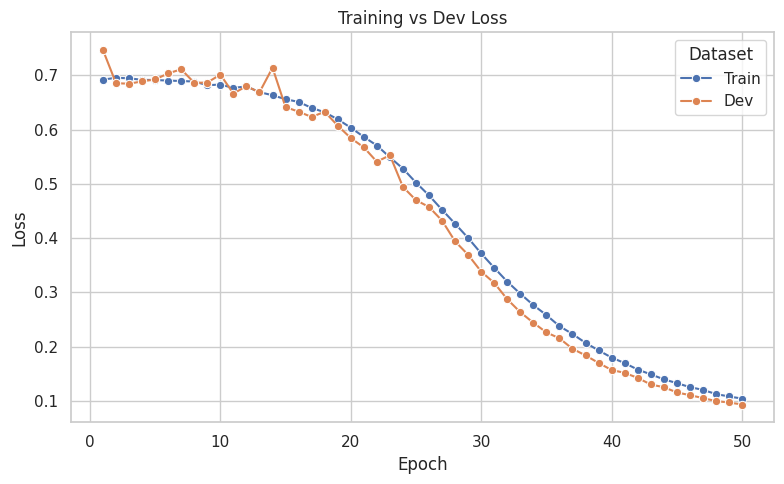

In [82]:
import pandas as pd

epochs = list(range(1, len(losses['train_losses']) + 1))
df = pd.DataFrame({
    "Epoch": epochs * 2,
    "Loss": losses['train_losses'] + losses["dev_losses"],
    "Type": ["Train"] * len(losses['train_losses'] ) + ["Dev"] * len(losses['train_losses'] )
})

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Type", marker="o")

plt.title("Training vs Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

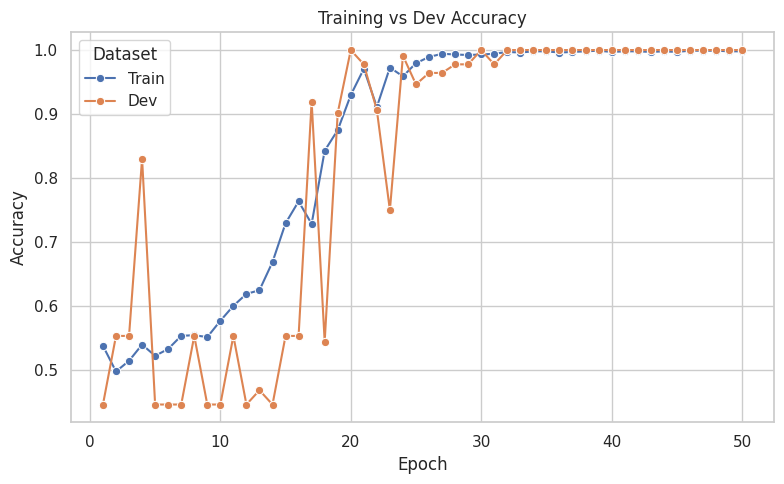

In [83]:
import pandas as pd

epochs = list(range(1, len(losses['train_accuracies']) + 1))
df = pd.DataFrame({
    "Epoch": epochs * 2,
    "Accuracy": losses['train_accuracies'] + losses["dev_accuracies"],
    "Type": ["Train"] * len(losses['train_accuracies'] ) + ["Dev"] * len(losses['train_accuracies'] )
})

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="Epoch", y="Accuracy", hue="Type", marker="o")

plt.title("Training vs Dev Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()



## Test score

In [84]:
with torch.no_grad():
  log_probs = classifier(X_test)
  y_pred = torch.argmax(log_probs,dim=1)

  loss = loss_fn(log_probs,y_test.long())
  accuracy = accuracy_score(y_pred,y_test)

  print(f"{'Test Loss:':<15} {loss.item()}")
  print(f"{'Test Accuracy:':<15} {accuracy}")

Test Loss:      0.0885494127869606
Test Accuracy:  1.0


## Inference

In [85]:
def inference(text:str):
  '''
  This function will return the language of the text
  '''
  vect = vectorizer.transform([text])
  vect = to_tensor(vect.toarray(),np.float32)
  log_probs = classifier(vect)
  y_pred = torch.argmax(log_probs,dim=1)
  return encoder.inverse_transform(y_pred)

In [87]:
fr_text = "je m'appel Cédric"
en_text = "my name is Cedric"


print(f"The language of this text: '{fr_text}' is -> {inference(fr_text)[0]} ")
print(f"The language of this text: '{en_text}' is -> {inference(en_text)[0]} ")

The language of this text: 'je m'appel Cédric' is -> FRENCH 
The language of this text: 'my name is Cedric' is -> ENGLISH 


## Saving the model to my huggingFace space

In [62]:
# Save the model
torch.save(classifier.state_dict(), 'language_classifier.pth')

In [66]:
!pip install huggingface_hub


In [68]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `tts-coqui` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticat

In [76]:
from huggingface_hub import HfApi, HfFolder

api = HfApi()

model_path = "/content/model/"


from huggingface_hub import HfApi

api = HfApi(token="YOUR TOKEN")
api.upload_folder(
    folder_path=model_path,
    repo_id="rahim707/language-identification-pytroch",
    repo_type="model",
)


language_classifier.pth:   0%|          | 0.00/339k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rahim707/language-identification-pytroch/commit/41cb840e10c1f2b915041cd623e4ae32bdac9a2e', commit_message='Upload folder using huggingface_hub', commit_description='', oid='41cb840e10c1f2b915041cd623e4ae32bdac9a2e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rahim707/language-identification-pytroch', endpoint='https://huggingface.co', repo_type='model', repo_id='rahim707/language-identification-pytroch'), pr_revision=None, pr_num=None)